# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [12]:
# Load the dataset
netcdf_file_path = "Data/12_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 40B 2022-01-01 ... 2022-01-01T04:00:00
  * lat      (lat) float32 20B 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 20B 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 1kB ...
    v        (time, lat, lon) float64 1kB ...
    stdu     (time, lat, lon) float64 1kB ...
    stdv     (time, lat, lon) float64 1kB ...
    cov      (time, lat, lon) float64 1kB ...
    velo     (time, lat, lon) float64 1kB ...
    head     (time, lat, lon) float64 1kB ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  SOPU (measured);POZZ (measured);MRAG (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 16:56:38
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

In [13]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['v','stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove rows where 'u' has NaN values
df = df.dropna(subset=['u'])

df

,time,lat,lon,u
496,2022-01-01 00:00:00,35.989601,14.6097,-0.000941
589,2022-01-01 00:00:00,36.034100,14.8937,-0.340020
590,2022-01-01 00:00:00,36.034100,14.9342,-0.238157
591,2022-01-01 00:00:00,36.034100,14.9748,0.083874
632,2022-01-01 00:00:00,36.056400,14.8937,-0.328633
...,...,...,...,...
19493416,2022-12-31 23:00:00,36.880199,14.1230,0.327331
19493417,2022-12-31 23:00:00,36.880199,14.1635,0.400850
19493418,2022-12-31 23:00:00,36.880199,14.2041,0.460808
19493419,2022-12-31 23:00:00,36.880199,14.2447,0.578678


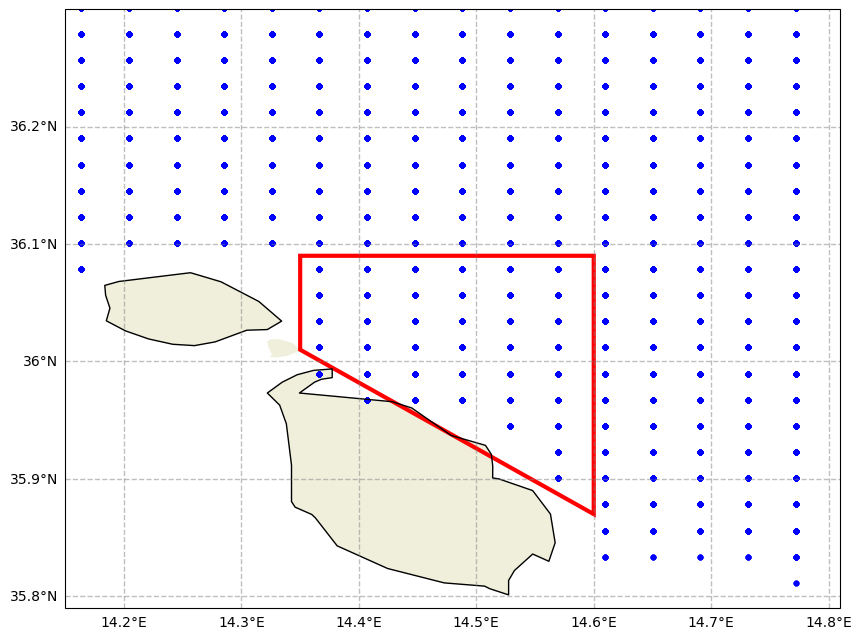

In [16]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

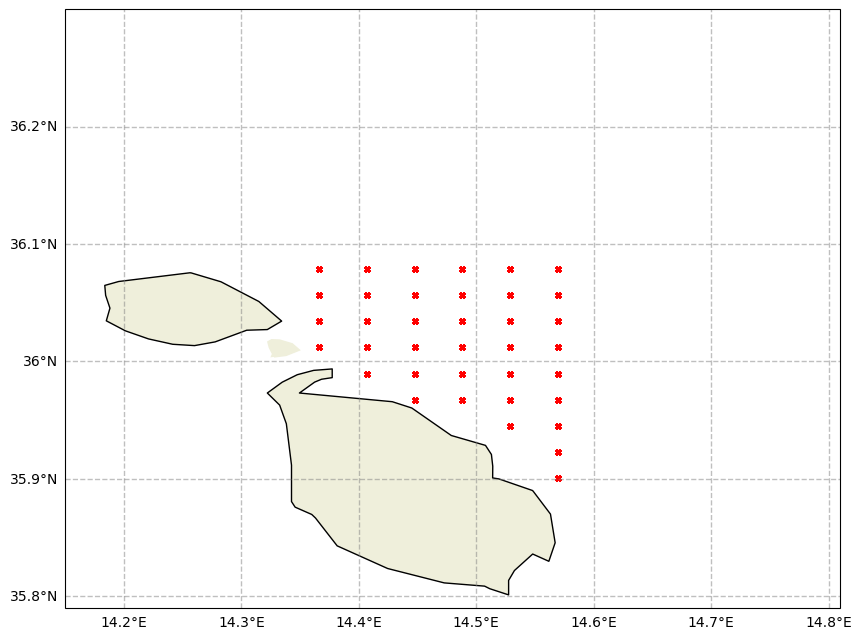

In [17]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

In [18]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.366399765014648, 36.07870101928711)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.366399765014648, 36.03409957885742)
(14.406900405883789, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.366399765014648, 36.056400299072266)
(14.406900405883789, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.406900405883789, 36.07870101928711)
(14.447500228881836, 36.07870101928711)
(14.528599739074707, 36.07870101928711)
(14.569199562072754, 36.07870101928711)
(14.447500228881836, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.406900405883789, 36.01190185546875)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.48799991607666, 3

### Exctract data only for a single pair of coordinates

In [20]:
# Coordinates 
target_lat = 36.07870101928711
target_lon = 14.366399765014648

# Filter the DataFrame for the exact coordinates
df_point = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u
662,2022-01-01 00:00:00,36.078701,14.3664,-0.145248
2898,2022-01-01 01:00:00,36.078701,14.3664,-0.047317
5134,2022-01-01 02:00:00,36.078701,14.3664,-0.022374
7370,2022-01-01 03:00:00,36.078701,14.3664,0.041652
9606,2022-01-01 04:00:00,36.078701,14.3664,0.052409
...,...,...,...,...
19482930,2022-12-31 19:00:00,36.078701,14.3664,-0.152878
19485166,2022-12-31 20:00:00,36.078701,14.3664,-0.171337
19487402,2022-12-31 21:00:00,36.078701,14.3664,-0.198856
19489638,2022-12-31 22:00:00,36.078701,14.3664,-0.206298
